In [9]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
#from hp_utils import *
import numpy as np
from sklearn import metrics
import torch.optim as optim
#from sklearn.manifold import TSNE
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from mlp_utils import *

In [2]:
df = pd.read_csv("/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv")

In [7]:
Data = DataSplit(df)
Data.split_data('mortality', random_state=1)

X,V,T = Data.get_type('vd_')
train_set = CustomDataset(X.values.tolist(), Data.y_train.tolist())
val_set = CustomDataset(V.values.tolist(), Data.y_validation.tolist())

# Create a RandomSampler with a fixed seed
sampler = RandomSampler(train_set, replacement=False)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers = 5)
val_loader = DataLoader(val_set, batch_size=32, num_workers = 5)

/home/liv/multimodal_healthcare/mlp_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_death_small48['y'] = 1
/home/liv/multimodal_healthcare/mlp_utils.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive_big48['y'] = 0
/home/liv/multimodal_healthcare/mlp_utils.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

Loss: 464.1041, Accuracy: 665.2500
f1:  0.0
auc:  0.5


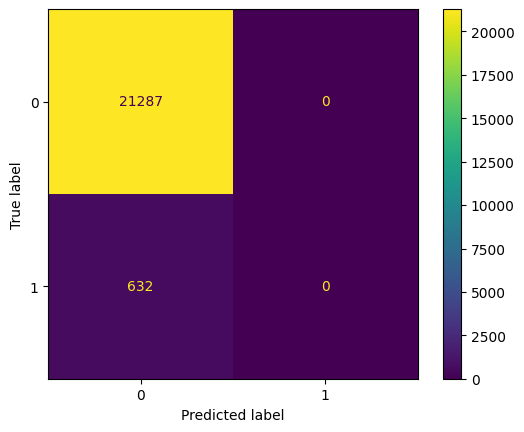

In [8]:
w0 = len(Data.y_train)/(2*sum(Data.y_train == 0))
w1 = len(Data.y_train)/(2*sum(Data.y_train == 1))
weights = torch.tensor([w0, w1], dtype = torch.float).to("cuda")


# Setting model and hyperparameters
model = ProjectionNN()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=7)
loss_fn = nn.CrossEntropyLoss(weight=weights)
#loss_fn = FocalLoss(gamma=-3)

num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


def output_to_label(z):
    """Map network output z to a hard label {0, 1}
    
    Args:
        z (Tensor): Probabilities for each sample in a batch.
    Returns:
        c (Tensor): Hard label {0, 1} for each sample in a batch
    """
    # YOUR CODE HERE
    c = torch.round(z)
    return c.long()

val_loss_cum = 0
val_acc_cum = 0
model.eval()
preds = []
with torch.no_grad():
    for batch_index, (x, y) in enumerate(val_loader, 1):
        inputs, labels = x.to(device), y.to(device)

        emb = model.forward(inputs)
        #word_embs_extended = word_embs.repeat(len(inputs),1,1).detach()

        #concatted = torch.cat((word_embs_extended, emb), dim=1).to(torch.float16)
        #logits = custom_output(emb, gemma)

        batch_loss = loss_fn(emb, labels.long())
        val_loss_cum += batch_loss.item()
        hard_preds = output_to_label(emb)
        hard_preds = torch.argmax(hard_preds, dim=1)
        preds.extend(hard_preds)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        val_acc_cum += acc_batch_avg
print(f'Loss: {val_loss_cum:.4f}, Accuracy: {val_acc_cum:.4f}')


numpy_arrays = [t.cpu().numpy() for t in preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(Data.y_validation.tolist(), preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

fig = plt.gcf()


f1 = metrics.f1_score(Data.y_validation.tolist(), preds)
auc = metrics.roc_auc_score(Data.y_validation.tolist(), preds)
print('f1: ', f1)
print('auc: ', auc)

Epoch 1/10: 100%|██████████| 1786/1786 [00:04<00:00, 386.63batch/s]


Epoch [1/5], Loss: 914239.9891


Epoch 2/10: 100%|██████████| 1786/1786 [00:05<00:00, 350.40batch/s]


Epoch [2/5], Loss: 830643.7307


Epoch 3/10: 100%|██████████| 1786/1786 [00:04<00:00, 374.66batch/s]


Epoch [3/5], Loss: 658050.7050


Epoch 4/10: 100%|██████████| 1786/1786 [00:04<00:00, 376.14batch/s]


Epoch [4/5], Loss: 453704.9405


Epoch 5/10: 100%|██████████| 1786/1786 [00:04<00:00, 384.20batch/s]


Epoch [5/5], Loss: 401106.6183


Epoch 6/10: 100%|██████████| 1786/1786 [00:04<00:00, 378.09batch/s]


Epoch [6/5], Loss: 278903.5145


Epoch 7/10: 100%|██████████| 1786/1786 [00:04<00:00, 373.81batch/s]


Epoch [7/5], Loss: 173651.3963


Epoch 8/10: 100%|██████████| 1786/1786 [00:05<00:00, 351.94batch/s]


Epoch [8/5], Loss: 254564.2777


Epoch 9/10: 100%|██████████| 1786/1786 [00:04<00:00, 363.08batch/s]


Epoch [9/5], Loss: 189668.4164


Epoch 10/10: 100%|██████████| 1786/1786 [00:05<00:00, 329.58batch/s]

Epoch [10/5], Loss: 131128.8972


Validation - Epoch [10/10], Loss: 8573.7251, Accuracy: 28.6939
f1:  0.09236947791164658
auc:  0.5832896797884086


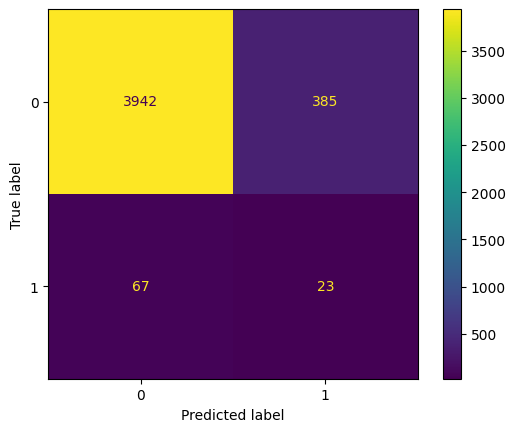

In [8]:
projection_model = torch.load('results_0/model.pth').to('cuda')

# Instantiate your custom model
clf_head = ClfHead2(projection_size=1)

# Move the model to GPU if available
clf_head.to('cuda')

w1 = len(Data.y_train) / (2 * sum(Data.y_train == 1))

# Define class weights tensor
class_weights = torch.tensor([w1], dtype=torch.float).to("cuda")
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = torch.optim.Adam(clf_head.parameters(), lr=0.001, weight_decay=0.001)
best_loss = 10
closing = 0
for epoch in range(10):
    clf_head.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{10}', unit='batch'):  # Adjust train_loader according to your data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        #proj_outputs = projection_model(inputs)
        #outputs = clf_head(proj_outputs)
        # Forward pass
        reshaped_inputs = inputs.unsqueeze(1)
        outputs = clf_head(reshaped_inputs)

        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{5}], Loss: {epoch_loss:.4f}')
    if epoch_loss >= best_loss:
        closing +=1
    else:
        best_loss = epoch_loss
        closing = 0

 # Evaluation
clf_head.eval()
val_running_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        #proj_outputs = projection_model(inputs)
        #outputs = clf_head(proj_outputs)

        reshaped_inputs = inputs.unsqueeze(1)
        outputs = clf_head(reshaped_inputs)
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels.float().unsqueeze(1))  
        val_running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).int()
        all_preds.extend(predicted)
        all_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_epoch_loss = val_running_loss / len(val_loader.dataset)
val_accuracy = correct / total
print(f'Validation - Epoch [{epoch+1}/{10}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}')

numpy_arrays = [t.cpu().numpy() for t in all_preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(Data.y_validation.tolist(), preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

fig = plt.gcf()

# Save the figure
fig.savefig('clf_confusion_matrix2.png', dpi=300)

f1 = metrics.f1_score(Data.y_validation.tolist(), preds)
auc = metrics.roc_auc_score(Data.y_validation.tolist(), preds)
print('f1: ', f1)
print('auc: ', auc)


Epoch 1/10: 100%|██████████| 1786/1786 [00:32<00:00, 54.54batch/s]


Epoch [1/5], Loss: 1.1208


Epoch 2/10: 100%|██████████| 1786/1786 [00:32<00:00, 54.53batch/s]


Epoch [2/5], Loss: 1.1679


Epoch 3/10: 100%|██████████| 1786/1786 [00:32<00:00, 54.18batch/s]


Epoch [3/5], Loss: 1.2278


Epoch 4/10: 100%|██████████| 1786/1786 [00:32<00:00, 54.15batch/s]


Epoch [4/5], Loss: 1.1979


Epoch 5/10: 100%|██████████| 1786/1786 [00:32<00:00, 54.26batch/s]


Epoch [5/5], Loss: 1.1186


Epoch 6/10: 100%|██████████| 1786/1786 [00:33<00:00, 53.87batch/s]


Epoch [6/5], Loss: 1.1234


Epoch 7/10: 100%|██████████| 1786/1786 [00:33<00:00, 53.93batch/s]


Epoch [7/5], Loss: 1.1144


Epoch 8/10: 100%|██████████| 1786/1786 [00:33<00:00, 53.98batch/s]


Epoch [8/5], Loss: 1.0394


Epoch 9/10: 100%|██████████| 1786/1786 [00:32<00:00, 54.46batch/s]


Epoch [9/5], Loss: 1.0628


Epoch 10/10: 100%|██████████| 1786/1786 [00:33<00:00, 53.96batch/s]

Epoch [10/5], Loss: 1.0815


Validation - Epoch [10/10], Loss: 0.9243, Accuracy: 28.3686
f1:  0.07076350093109869
auc:  0.5560986570115296


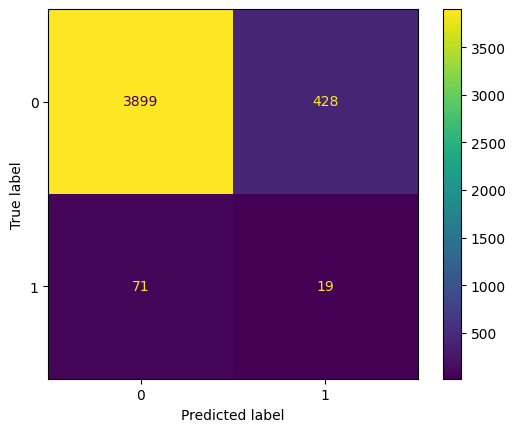

In [9]:
projection_model = torch.load('results_0/model.pth').to('cuda')

# Instantiate your custom model
clf_head = ClfHead(projection_size=12)

# Move the model to GPU if available
clf_head.to('cuda')

w1 = len(Data.y_train) / (2 * sum(Data.y_train == 1))

# Define class weights tensor
class_weights = torch.tensor([w1], dtype=torch.float).to("cuda")
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = torch.optim.Adam(clf_head.parameters(), lr=0.001, weight_decay=0.001)
best_loss = 10
closing = 0
for epoch in range(10):
    clf_head.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{10}', unit='batch'):  # Adjust train_loader according to your data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        proj_outputs = projection_model(inputs)
        outputs = clf_head(proj_outputs)
        # Forward pass
        #reshaped_inputs = inputs.unsqueeze(1)
        #outputs = clf_head(reshaped_inputs)

        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{5}], Loss: {epoch_loss:.4f}')
    if epoch_loss >= best_loss:
        closing +=1
    else:
        best_loss = epoch_loss
        closing = 0

 # Evaluation
clf_head.eval()
val_running_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        proj_outputs = projection_model(inputs)
        outputs = clf_head(proj_outputs)

        #reshaped_inputs = inputs.unsqueeze(1)
        #outputs = clf_head(reshaped_inputs)
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels.float().unsqueeze(1))  
        val_running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).int()
        all_preds.extend(predicted)
        all_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_epoch_loss = val_running_loss / len(val_loader.dataset)
val_accuracy = correct / total
print(f'Validation - Epoch [{epoch+1}/{10}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}')

numpy_arrays = [t.cpu().numpy() for t in all_preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(Data.y_validation.tolist(), preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

fig = plt.gcf()

# Save the figure
fig.savefig('clf_confusion_matrix2.png', dpi=300)

f1 = metrics.f1_score(Data.y_validation.tolist(), preds)
auc = metrics.roc_auc_score(Data.y_validation.tolist(), preds)
print('f1: ', f1)
print('auc: ', auc)

Epoch 1/10: 100%|██████████| 1786/1786 [00:31<00:00, 56.85batch/s]


Epoch [1/5], Loss: 1.1656


Epoch 2/10: 100%|██████████| 1786/1786 [00:31<00:00, 56.67batch/s]


Epoch [2/5], Loss: 1.0495


Epoch 3/10: 100%|██████████| 1786/1786 [00:31<00:00, 56.82batch/s]


Epoch [3/5], Loss: 1.1608


Epoch 4/10: 100%|██████████| 1786/1786 [00:31<00:00, 56.86batch/s]


Epoch [4/5], Loss: 1.2248


Epoch 5/10: 100%|██████████| 1786/1786 [00:31<00:00, 56.78batch/s]


Epoch [5/5], Loss: 1.2105


Epoch 6/10: 100%|██████████| 1786/1786 [00:31<00:00, 57.14batch/s]


Epoch [6/5], Loss: 1.0621


Epoch 7/10: 100%|██████████| 1786/1786 [00:31<00:00, 57.42batch/s]


Epoch [7/5], Loss: 1.0967


Epoch 8/10: 100%|██████████| 1786/1786 [00:31<00:00, 57.11batch/s]


Epoch [8/5], Loss: 1.0641


Epoch 9/10: 100%|██████████| 1786/1786 [00:31<00:00, 57.08batch/s]


Epoch [9/5], Loss: 1.0404


Epoch 10/10: 100%|██████████| 1786/1786 [00:31<00:00, 56.60batch/s]

Epoch [10/5], Loss: 1.1067


Validation - Epoch [10/10], Loss: 0.8575, Accuracy: 30.6525
f1:  0.06060606060606061
auc:  0.5215468762036822


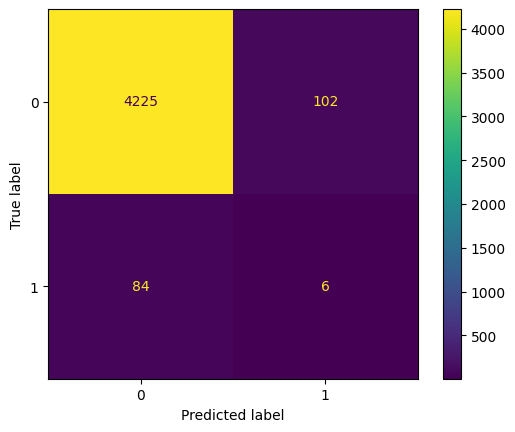

In [5]:
projection_model = torch.load('results_1/model.pth').to('cuda')

# Instantiate your custom model
clf_head = ClfHead(projection_size=12)

# Move the model to GPU if available
clf_head.to('cuda')

w1 = len(Data.y_train) / (2 * sum(Data.y_train == 1))

# Define class weights tensor
class_weights = torch.tensor([w1], dtype=torch.float).to("cuda")
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

optimizer = torch.optim.Adam(clf_head.parameters(), lr=0.001, weight_decay=0.001)
best_loss = 10
closing = 0
for epoch in range(10):
    clf_head.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{10}', unit='batch'):  # Adjust train_loader according to your data
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        proj_outputs = projection_model(inputs)
        outputs = clf_head(proj_outputs)
        # Forward pass
        #reshaped_inputs = inputs.unsqueeze(1)
        #outputs = clf_head(reshaped_inputs)

        loss = criterion(outputs.squeeze(), labels.float())
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{5}], Loss: {epoch_loss:.4f}')
    if epoch_loss >= best_loss:
        closing +=1
    else:
        best_loss = epoch_loss
        closing = 0

 # Evaluation
clf_head.eval()
val_running_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in val_loader:  
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        
        proj_outputs = projection_model(inputs)
        outputs = clf_head(proj_outputs)

        #reshaped_inputs = inputs.unsqueeze(1)
        #outputs = clf_head(reshaped_inputs)
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels.float().unsqueeze(1))  
        val_running_loss += loss.item() * inputs.size(0)

        # Calculate accuracy
        probabilities = torch.sigmoid(outputs)
        predicted = (probabilities > 0.5).int()
        all_preds.extend(predicted)
        all_labels.extend(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_epoch_loss = val_running_loss / len(val_loader.dataset)
val_accuracy = correct / total
print(f'Validation - Epoch [{epoch+1}/{10}], Loss: {val_epoch_loss:.4f}, Accuracy: {val_accuracy:.4f}')

numpy_arrays = [t.cpu().numpy() for t in all_preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(Data.y_validation.tolist(), preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

fig = plt.gcf()

# Save the figure
fig.savefig('clf_confusion_matrix2.png', dpi=300)

f1 = metrics.f1_score(Data.y_validation.tolist(), preds)
auc = metrics.roc_auc_score(Data.y_validation.tolist(), preds)
print('f1: ', f1)
print('auc: ', auc)

In [ ]:
class ClfHead(nn.Module):
    def __init__(self, projection_size):
        super(ClfHead, self).__init__()

        self.projection_size = projection_size

        # Define the classification head
        self.classification_head = nn.Sequential(
            nn.Linear(2048*self.projection_size,1024),
            #nn.Linear(110*1,1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)# Output layer with 1 unit for binary classification
        )

    def forward(self, x):
        # Flatten the output for the classification head
        batch_size, n_tokens, embedding_dimensions = x.size()
        #flattened = x.view(batch_size, -1)
        flattened = x.reshape(batch_size, -1)
        # Forward pass through the classification head
        output = self.classification_head(flattened)

        return output

In [5]:
class ClfHead2(nn.Module):
    def __init__(self, projection_size):
        super(ClfHead2, self).__init__()

        self.projection_size = projection_size

        # Define the classification head
        self.classification_head = nn.Sequential(
            nn.Linear(110*self.projection_size,1024),
            #nn.Linear(110*1,1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)# Output layer with 1 unit for binary classification
        )

    def forward(self, x):
        # Flatten the output for the classification head
        batch_size, n_tokens, embedding_dimensions = x.size()
        #flattened = x.view(batch_size, -1)
        flattened = x.reshape(batch_size, -1)
        # Forward pass through the classification head
        output = self.classification_head(flattened)

        return output

In [13]:
with open(r"results_2/train_losses.pkl", "rb") as input_file:
    train_losses = pickle.load(input_file)

with open(r"results_2/train_accs.pkl", "rb") as input_file:
    train_accs = pickle.load(input_file)

with open(r"results_2/val_losses.pkl", "rb") as input_file:
    val_losses = pickle.load(input_file)

with open(r"results_2/val_accs.pkl", "rb") as input_file:
    val_accs = pickle.load(input_file)

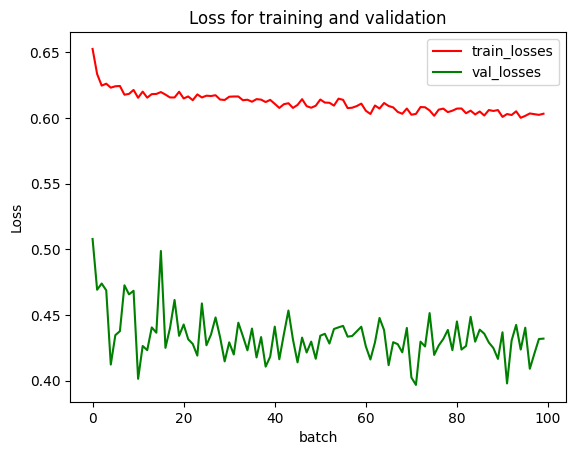

In [14]:
x = list(range(len(train_losses)))

repetitions = len(train_losses) // len(val_losses)
extended_val_loss = [element for element in val_losses for _ in range(repetitions)]

remaining_elements = len(train_losses) % len(val_losses)
if remaining_elements > 0:
    extended_val_loss += val_losses[:remaining_elements]

plt.plot(x, train_losses, color='r', label='train_losses')
plt.plot(x, extended_val_loss, color='g', label='val_losses')

plt.title('Loss for training and validation')
plt.ylabel('Loss')
plt.xlabel('batch')

plt.legend()

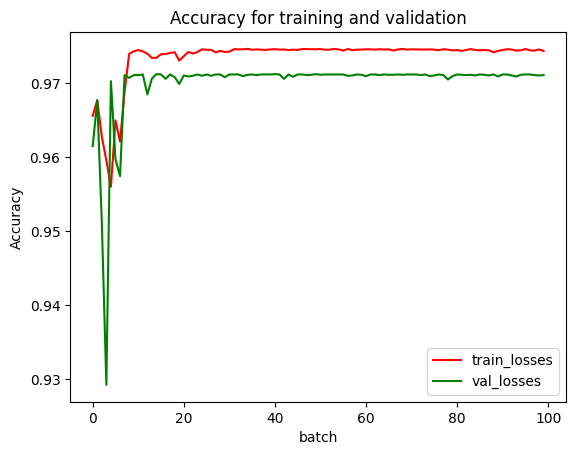

In [15]:
x = list(range(len(train_accs)))

repetitions = len(train_accs) // len(val_accs)
extended_val_accs = [element for element in val_accs for _ in range(repetitions)]

remaining_elements = len(train_accs) % len(val_accs)
if remaining_elements > 0:
    extended_val_accs += val_accs[:remaining_elements]

plt.plot(x, train_accs, color='r', label='train_losses')
plt.plot(x, extended_val_accs, color='g', label='val_losses')

plt.title('Accuracy for training and validation')
plt.ylabel('Accuracy')
plt.xlabel('batch')

plt.legend()